In [ ]:
from pathlib import Path
import numpy as np
import copy
import torch
import torchvision
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.datasets import CIFAR10, MNIST, QMNIST
from torchvision.transforms.transforms import Resize
from typing import Any, Callable, Dict, List, Optional, Tuple
import os
import os.path
import pickle
from typing import Any, Callable, Optional, Tuple
import numpy as np
from PIL import Image
from torchvision.datasets.utils import check_integrity, download_and_extract_archive
from torchvision.datasets.vision import VisionDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

> **Architectures.** For experiments on CIFAR-10, CIFAR-100 and CINIC-10, we use a variant of ResNet-18 (He et al., 2016). We adapted the ResNet18 to 32x32 images by modifying the architecture to remove the downsampling effect. We replaced the spatial downsampling of a strided convolution and max pooling in the original ResNet18, with a convolutional layer with 64 filters and a kernel size of 3x3. We also removed the average pooling at the end of the ResNet18. This ResNet18 variant is similar to Resnet20, just with more filters

**Resnet Architecture as mentioned in paper:** [ https://github.com/OATML/RHO-Loss/blob/4c88851742ce5397153f4fef80abd4682958ac56/src/models/modules/resnet_cifar.py#L86 ]


In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(
            planes, self.expansion * planes, kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])

def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])

def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])

def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

def resnet18_imagenet(pretrained=False, classes=10):
    model = torchvision.models.resnet18(pretrained=pretrained, num_classes=1000)
    model.conv1 = nn.Conv2d(
        3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
    )
    model.maxpool = nn.Identity()
    model.fc = nn.Linear(512, classes, bias=True)
    return model

def resnet50_imagenet(pretrained=False, classes=10):
    model = torchvision.models.resnet50(pretrained=pretrained, num_classes=1000)
    model.fc = nn.Linear(512, classes, bias=True)
    return model

Data loading, data splitting code from: https://github.com/OATML/RHO-Loss/blob/main/src/datamodules/datamodules.py , https://github.com/OATML/RHO-Loss/blob/main/src/datamodules/datasets/sequence_datasets.py



In [ ]:
class indices_CIFAR10(VisionDataset):
    base_folder = "cifar-10-batches-py"
    url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    filename = "cifar-10-python.tar.gz"
    tgz_md5 = "c58f30108f718f92721af3b95e74349a"
    train_list = [
        ["data_batch_1", "c99cafc152244af753f735de768cd75f"],
        ["data_batch_2", "d4bba439e000b95fd0a9bffe97cbabec"],
        ["data_batch_3", "54ebc095f3ab1f0389bbae665268c751"],
        ["data_batch_4", "634d18415352ddfa80567beed471001a"],
        ["data_batch_5", "482c414d41f54cd18b22e5b47cb7c3cb"],
    ]

    test_list = [
        ["test_batch", "40351d587109b95175f43aff81a1287e"],
    ]
    meta = {
        "filename": "batches.meta",
        "key": "label_names",
        "md5": "5ff9c542aee3614f3951f8cda6e48888",
    }

    def __init__(
        self,
        root: str,
        train: bool = True,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        sequence=None,
    ) -> None:

        super(indices_CIFAR10, self).__init__(
            root, transform=transform, target_transform=target_transform
        )

        self.train = train  # training set or test set

        self.download()

        if not self._check_integrity():
            raise RuntimeError(
                "Dataset not found or corrupted even though we tried to download it"
            )

        if self.train:
            downloaded_list = self.train_list
        else:
            downloaded_list = self.test_list

        self.data: Any = []
        self.targets = []

        # now load the picked numpy arrays
        for file_name, checksum in downloaded_list:
            file_path = os.path.join(self.root, self.base_folder, file_name)
            with open(file_path, "rb") as f:
                entry = pickle.load(f, encoding="latin1")
                self.data.append(entry["data"])
                if "labels" in entry:
                    self.targets.extend(entry["labels"])
                else:
                    self.targets.extend(entry["fine_labels"])

        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        self.data = self.data.transpose((0, 2, 3, 1))  # convert to HWC

        self._load_meta()
        if sequence is not None:
            self.sequence = sequence
        else:
            self.sequence = np.arange(len(self.data))

    def _load_meta(self) -> None:
        path = os.path.join(self.root, self.base_folder, self.meta["filename"])
        if not check_integrity(path, self.meta["md5"]):
            raise RuntimeError("Dataset metadata file not found or corrupted")
        with open(path, "rb") as infile:
            data = pickle.load(infile, encoding="latin1")
            self.classes = data[self.meta["key"]]
        self.class_to_idx = {_class: i for i, _class in enumerate(self.classes)}

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[self.sequence[index]], self.targets[self.sequence[index]]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return index, img, target

    def __len__(self) -> int:
        return len(self.sequence)

    def _check_integrity(self) -> bool:
        root = self.root
        for fentry in self.train_list + self.test_list:
            filename, md5 = fentry[0], fentry[1]
            fpath = os.path.join(root, self.base_folder, filename)
            if not check_integrity(fpath, md5):
                return False
        return True

    def download(self) -> None:
        if self._check_integrity():
            print("Files already downloaded and verified")
            return
        download_and_extract_archive(
            self.url, self.root, filename=self.filename, md5=self.tgz_md5
        )

    def extra_repr(self) -> str:
        return "Split: {}".format("Train" if self.train is True else "Test")

class CIFAR10DataModule:
    def __init__(self, data_dir="./data", batch_size=960, test_batch_size=100, num_workers=4):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.test_batch_size = test_batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
        self.data_aug_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

    def setup(self, double_irlomo=False):
        full_dataset = indices_CIFAR10(self.data_dir, train=True, transform=self.data_aug_transform)

        indices = list(range(len(full_dataset)))
        train_indices = indices[::2]
        val_indices = indices[1::2]

        self.train_split_1 = Subset(full_dataset, train_indices)
        self.train_split_2 = Subset(full_dataset, val_indices)
        self.train_split_2_indices = val_indices  # needed for irreducible loss tracking

        self.test_dataset = indices_CIFAR10(self.data_dir, train=False, transform=self.transform)

    def get_train_loader_split1(self):
        return DataLoader(self.train_split_1, batch_size=128, shuffle=True, num_workers=self.num_workers)

    def get_train_loader_split2(self):
        return DataLoader(self.train_split_2, batch_size=1, shuffle=False, num_workers=self.num_workers)

    def get_test_loader(self):
        return DataLoader(self.test_dataset, batch_size=self.test_batch_size, shuffle=False, num_workers=self.num_workers)




**Training IL Model:**

> **Data augmentation:** On CIFAR-10, CIFAR-100, and CINIC-10, we train using data augmentation (random crop and horizontal flip), both for training the IL model, and in the main training runs. Remember that we only compute the irreducible losses once at the start of training.

> We can efficiently compute the IL with an “irreducible loss model" (IL model) that is smaller than the target model and has low accuracy . ResNet18 IL model trained for 37x fewer steps than each target model.

Irreducible loss models can be small and cheap. In our
default setting, both the target model and IL model have the same architecture (ResNet-18).The smaller IL model accelerates training as much or more than the larger model, even though its final accuracy is far lower than the target ResNet18 (11.5% lower on CIFAR-10, 7% on CIFAR-100, and 8.1% on CINIC-10).



In [ ]:
# === CONTINUATION CODE: RHO-LOSS Training on CIFAR-10 ===

import torch
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm, trange
import random
import warnings
warnings.filterwarnings("ignore")

# ====== Set device and seed ======
torch.manual_seed(42)
random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ====== Initialize DataModule and Prepare Splits ======
dm = CIFAR10DataModule()
dm.setup()

train_loader_il = dm.get_train_loader_split1()
eval_loader_il = dm.get_train_loader_split2()
test_loader = dm.get_test_loader()
train_ids = dm.train_split_2_indices

# ====== Step 1: Train IL Model ======
il_model = ResNet18().to(device)
il_optimizer = optim.AdamW(il_model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

for epoch in trange(30, desc="Training IL Model"):
    il_model.train()
    correct, total = 0, 0
    for _, x, y in train_loader_il:
        x, y = x.to(device), y.to(device)
        il_optimizer.zero_grad()
        logits = il_model(x)
        loss = criterion(logits, y)
        loss.backward()
        il_optimizer.step()
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)
    acc = 100.0 * correct / total
    print(f"[IL Model] Epoch {epoch+1}: Accuracy = {acc:.2f}%")
    if acc >= 40.0:
        break

100%|██████████| 170M/170M [00:12<00:00, 13.4MB/s]


Files already downloaded and verified


Training IL Model:   0%|          | 0/30 [00:22<?, ?it/s]

[IL Model] Epoch 1: Accuracy = 42.02%


**Compute Irreducible Loss**

In [ ]:
print("Computing irreducible loss on split_2...")
il_model.eval()
irreducible_loss = {}
with torch.no_grad():
    for idx, (_, x, y) in tqdm(zip(train_ids, eval_loader_il), total=len(train_ids), desc="Computing IL"):
        x, y = x.to(device), y.to(device)
        loss = F.cross_entropy(il_model(x), y).item()
        irreducible_loss[idx] = loss

Computing irreducible loss on split_2...


Computing IL: 100%|██████████| 25000/25000 [02:34<00:00, 161.79it/s]


**Pure RHO vs RHO+Curriculum Hybrid Approach:**

[hybrid] Epoch 1: Accuracy = 12.77%
[hybrid] Epoch 2: Accuracy = 14.69%
[hybrid] Epoch 3: Accuracy = 14.77%
[hybrid] Epoch 4: Accuracy = 16.99%
[hybrid] Epoch 5: Accuracy = 20.62%
[hybrid] Epoch 6: Accuracy = 25.48%
[hybrid] Epoch 7: Accuracy = 36.66%
[hybrid] Epoch 8: Accuracy = 35.95%
[hybrid] Epoch 9: Accuracy = 40.01%
[hybrid] Epoch 10: Accuracy = 42.76%
[hybrid] Epoch 11: Accuracy = 47.46%
[hybrid] Epoch 12: Accuracy = 45.00%
[hybrid] Epoch 13: Accuracy = 46.41%
[hybrid] Epoch 14: Accuracy = 50.47%
[hybrid] Epoch 15: Accuracy = 48.92%
[hybrid] Epoch 16: Accuracy = 54.23%
[hybrid] Epoch 17: Accuracy = 52.73%
[hybrid] Epoch 18: Accuracy = 52.32%
[hybrid] Epoch 19: Accuracy = 50.94%
[hybrid] Epoch 20: Accuracy = 53.73%
[hybrid] Epoch 21: Accuracy = 57.22%
[hybrid] Epoch 22: Accuracy = 53.81%
[hybrid] Epoch 23: Accuracy = 53.29%
[hybrid] Epoch 24: Accuracy = 57.96%
[hybrid] Epoch 25: Accuracy = 56.32%
[hybrid] Epoch 26: Accuracy = 56.88%
[hybrid] Epoch 27: Accuracy = 56.93%
[hybrid] E

TypeError: '>' not supported between instances of 'float' and 'NoneType'

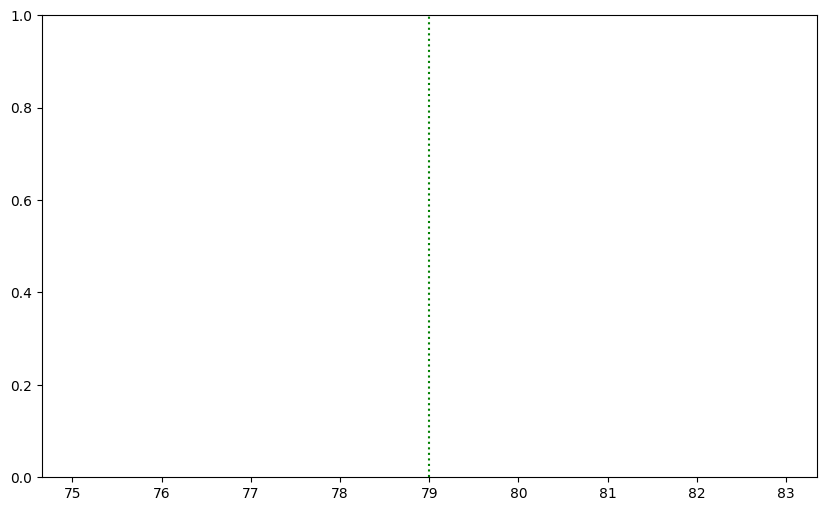

In [ ]:
import time
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# === Training Pipeline for Both Methods ===
def train_model(name="pure_rho", curriculum_epochs=0):
    model = ResNet18().to(device)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    topk = 320
    test_acc_list = []
    start_time = time.time()

    for epoch in range(1, 300):
        model.train()
        random.shuffle(train_ids)

        for i in range(0, len(train_ids), topk):
            ids = train_ids[i:i+topk]
            x_b, y_b, il_b = [], [], []
            for idx in ids:
                _, x, y = dm.train_split_2.dataset[idx]
                x_b.append(x)
                y_b.append(y)
                il_b.append(irreducible_loss[idx])

            if len(x_b) < 32:
                continue

            x_tensor = torch.stack(x_b).to(device)
            y_tensor = torch.tensor(y_b).to(device)
            il_tensor = torch.tensor(il_b).to(device)

            logits = model(x_tensor)
            losses = F.cross_entropy(logits, y_tensor, reduction='none')

            if epoch <= curriculum_epochs:
                # During curriculum phase, select easiest examples (lowest loss)
                top_indices = torch.topk(-losses, 32).indices
            else:
                # After curriculum phase, use RHO-LOSS selection
                rho = losses - il_tensor
                top_indices = torch.topk(rho, 32).indices

            selected_loss = losses[top_indices].mean()
            optimizer.zero_grad()
            selected_loss.backward()
            optimizer.step()

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for _, x, y in test_loader:
                x, y = x.to(device), y.to(device)
                pred = model(x).argmax(1)
                correct += (pred == y).sum().item()
                total += y.size(0)
        acc = 100.0 * correct / total
        test_acc_list.append(acc)
        print(f"[{name}] Epoch {epoch}: Accuracy = {acc:.2f}%")
        if acc >= 80.0:
            break

    time_taken = time.time() - start_time
    return test_acc_list, time_taken

# === Run both methods ===
hybrid_acc, time_hybrid = train_model("hybrid", curriculum_epochs=4)

# === Plot and Compare ===
def find_epoch(acc_list, target):
    for i, acc in enumerate(acc_list):
        if acc >= target:
            return i + 1
    return None

epochs_hybrid = list(range(1, len(hybrid_acc)+1))

hybrid_70 = find_epoch(hybrid_acc, 70)
hybrid_80 = find_epoch(hybrid_acc, 80)

plt.figure(figsize=(10, 6))

plt.axvline(x=hybrid_70, color='green', linestyle=':', label='Hybrid hits 70%')
plt.axvline(x=hybrid_80, color='green', linestyle='--', label='Hybrid hits 80%')

plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.title("Comparison: RHO-LOSS vs Curriculum+RHO Training")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# === Print Time Comparison ===
print("\n=== Time to reach 80% accuracy ===")
print(f"Curriculum + RHO: {time_hybrid:.2f} seconds")
